# 프로젝트 : 네이버 영화리뷰 감성분석 도전하기

### 📚 Import libraries & packages

In [1]:
# import utility tools
from collections import Counter
import os

# import data tools
import numpy as np
import pandas as pd
from konlpy.tag import Mecab    # (Python Korean something)

# import visual tools
import matplotlib.pyplot as plt

# import ML tools
import sklearn.model_selection as model_selection
import tensorflow as tf
from gensim.models import keyedvectors

### 📚 Define constants

In [2]:
# word-index dictionary constants
EMPTY_STR = ""

PAD_STR = "<PAD>"
PAD_NUM = 0
BOS_STR = "<BOS>"
BOS_NUM = 1
UNK_STR = "<UNK>"
UNK_NUM = 2
UNU_STR = "<UNUSED>"
UNU_NUM = 3


# ML algorithms type
RNN = 1
LSTM = 1
CNN = 2
POOL = 3
RNN_64 = 64
LSTM_64 = 64


# hyper-parameters
EPOCHS = 7
BATCH_SIZE = 64
VERBOSE = 0

TOTAL_WORDS = 10000
EMB_VEC_DIM = 100


# data file path
file_path = os.getenv('HOME')+'/aiffel/sentiment_classification/data/'

### 📚 Define useful embedding methods

In [3]:
# convert each word in one sentence into index number
# INPUT  : list of strings (each string = one sentence),
#          dictionary which KEY is word string and VALUE is corresponding index number
# OUTPUT : 2D numpy array (ROW : each sentence, COL : index number of each word)
def encodeSentence(sentence_list, word_to_num_dict):
    results = []
    for sentence in sentence_list:
        nums = []
        nums.append(BOS_NUM)
        
        for word in sentence.split():
            if word in word_to_num_dict:
                nums.append(world_to_num_dict[word])
            else:
                nums.append(UNK_NUM)
                
        results.append(nums)
        
    return np.array(results, dtype = object)



# convert numbers into word strings and merge as one sentence string
# INPUT  : 2D numpy array (ROW: each sentences, COL : index number of each word),
#          dictionary which KEY is index number and VALUE is corresponding word string
# OUTPUT : list of strings (each string = one sentences)
def decodeSentences(nums_list, num_to_word_dict):
    results = []
    for nums in nums_list:
        words = []
        for n in nums:
            if n == BOS_NUM or n == PAD_NUM:
                continue
            elif n == UNK or n not in num_to_word_dict:
                words.append(UNK_STR)
            else:
                words.append(num_to_word_dict[n])
                
        results.append("".join(words))

    return np.array(results, dtype = object)



# get a dictionary that KEY and VALUE are switched
def convertDict(input_dictionary):
    converted_dict = {}
    for key, value in input_dictionary.items():
        converted_dict[value] = key
    return converted_dict

### 📚 Define Korean data loader method

In [4]:
def loadKoreanData(train_data, test_data, num_words=TOTAL_WORDS):
    tokenizer = Mecab()
    stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']

    # remove duplicated & null values
    train_data.drop_duplicates(subset = ["document"], inplace = True)
    train_data = train_data.dropna(how = "any") 
    test_data.drop_duplicates(subset = ["document"], inplace = True)
    test_data = test_data.dropna(how = "any") 
    
    X_train = []
    for sentence in train_data["document"]:
        words = tokenizer.morphs(sentence)  # split sentence into words
        words = [w for w in words if not w in stopwords]  # filter stopwords
        X_train.append(words)

    X_test = []
    for sentence in test_data["document"]:
        temp_X = tokenizer.morphs(sentence) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        X_test.append(temp_X)
    

    every_words = np.concatenate(X_train).tolist()    # list for every words in X_train
    counter = Counter(every_words)
    counter = counter.most_common(TOTAL_WORDS - 4)    # -4 for <PAD>, <BOS>, <UNK>, <UNU>
    common_words = [PAD_STR, BOS_STR, UNK_STR, UNU_STR] + [key for key, _ in counter]
    word_to_num_dict = {word: num for num, word in enumerate(common_words)}
    num_to_word_dict = convertDict(word_to_num_dict)
        
        
    def encodeWords(words):
        return [word_to_num_dict[w] if w in word_to_num_dict else UNK_NUM for w in words]
        
    X_train = np.array(list(map(encodeWords, X_train)), dtype = object)
    X_test = np.array(list(map(encodeWords, X_test)), dtype = object)
    y_train = np.array(list(train_data["label"]))
    y_test = np.array(list(test_data["label"]))
        
    return X_train, y_train, X_test, y_test, word_to_num_dict, num_to_word_dict

### 📚 Define useful ML methods

In [5]:
# decide proper "maxlen" argument value for pad_sequences() 
def decideMaxlen(X_train, X_test):
    X = list(X_train) + list(X_test)
    sentence_length_info = np.array([len(sentence) for sentence in list(X)])

    length_mean = np.mean(sentence_length_info)
    length_max = np.max(sentence_length_info)
    length_std = np.std(sentence_length_info)

    maxlen = length_mean + length_std * 2
    return int(maxlen)



# generate a machine learning model with special structres
# structure can be decided according to "model_structure" argument
def genMLmodel(embedding_flag, embedding_matrix, maxlen, total_words = TOTAL_WORDS, vec_dim = EMB_VEC_DIM, model_structure = RNN):
    model = tf.keras.Sequential()
    
    if embedding_flag == False:
        model.add(tf.keras.layers.Embedding(total_words, vec_dim, input_shape=(None,)))
    else:
        model.add(tf.keras.layers.Embedding(total_words,
                                        vec_dim,
                                        embeddings_initializer = tf.keras.initializers.Constant(embedding_matrix),  # 카피한 임베딩을 여기서 활용
                                        input_length = maxlen,                            
                                        trainable = True))   # trainable을 True로 주면 Fine-tuning
        
    
    if model_structure == RNN or model_structure == LSTM:
        model.add(tf.keras.layers.LSTM(8))   # 가장 널리 쓰이는 RNN인 LSTM 레이어를 사용하였습니다. 이때 LSTM state 벡터의 차원수는 8로 하였습니다. (변경 가능)
        model.add(tf.keras.layers.Dense(8, activation = 'relu'))
        model.add(tf.keras.layers.Dense(1, activation = 'sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.
        
    elif model_structure == RNN_64 or model_structure == LSTM_64:
        model.add(tf.keras.layers.LSTM(64))   # 가장 널리 쓰이는 RNN인 LSTM 레이어를 사용하였습니다. 이때 LSTM state 벡터의 차원수는 8로 하였습니다. (변경 가능)
        model.add(tf.keras.layers.Dense(8, activation = 'relu'))
        model.add(tf.keras.layers.Dense(1, activation = 'sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.
    
    elif model_structure == CNN:
        model.add(tf.keras.layers.Conv1D(vec_dim, 7, activation='relu'))
        model.add(tf.keras.layers.MaxPooling1D(5))
        model.add(tf.keras.layers.Conv1D(vec_dim, 7, activation='relu'))
        model.add(tf.keras.layers.GlobalMaxPooling1D())
        model.add(tf.keras.layers.Dense(8, activation='relu'))
        model.add(tf.keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

    elif model_structure == POOL:
        model.add(tf.keras.layers.GlobalMaxPooling1D())
        model.add(tf.keras.layers.Dense(8, activation='relu'))
        model.add(tf.keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.
    
    #print(model.summary())
    return model



# visualize ML performance
# draw two lineplots of loss by epochs and accuracy by epochs
def displayPerformance(performance):
    # define data
    acc = performance["accuracy"]
    val_acc = performance["val_accuracy"]
    loss = performance["loss"]
    val_loss = performance["val_loss"]
    
    epochs = range(1, len(acc) + 1)
    
    
    # design plot figure
    fig = plt.figure(figsize = (12, 5))
    
    # subplot for loss
    subfig1 = fig.add_subplot(1, 2, 1)
    subfig1.plot(epochs, loss, label = "training", color = "magenta")
    subfig1.plot(epochs, val_loss, label = "validation", color = "pink")
    subfig1.set_xlabel("Epochs")
    subfig1.set_ylabel("Loss")
    subfig1.set_title("Training/Validation Loss by Epochs")
    subfig1.legend()
    subfig1.grid()
    
    # subplot for loss
    subfig2 = fig.add_subplot(1, 2, 2)
    subfig2.plot(epochs, acc, label = "training", color = "magenta")
    subfig2.plot(epochs, val_acc, label = "validation", color = "pink")
    subfig2.set_xlabel("Epochs")
    subfig2.set_ylabel("Accuracy")
    subfig2.set_title("Training/Validation Accuracy by Epochs")
    subfig2.legend()
    subfig2.grid()
    
    # display plot figure
    plt.show()
    print(">>> Minimum Validation Loss     : ", min(val_loss))
    print(">>> Maximum Validation Accuracy : ", max(val_acc))
    


# operate every commands step by step to perform ML test & evaluation
def learingPipeline(embedding_flag, embedding_matrix, maxlen, X, y, X_test, y_test, model = RNN, total_words = TOTAL_WORDS, vec_dim = EMB_VEC_DIM, epochs = EPOCHS, verbose = VERBOSE):
    # set model configurations
    model = genMLmodel(embedding_flag, embedding_matrix, maxlen, total_words, vec_dim, model_structure = model)
    model.compile(optimizer = "adam", loss = "binary_crossentropy", metrics=["accuracy"])
    # split data for training & validation
    X_train, X_valid, y_train, y_valid = model_selection.train_test_split(X, y)
    
    log = model.fit(X_train, y_train, epochs = epochs, batch_size = BATCH_SIZE, validation_data = (X_valid, y_valid), verbose = verbose)
    evaluation = model.evaluate(X_test, y_test, verbose = verbose)
    performance = log.history

    # report training & validatio performance
    print(">>> Training & validation report")
    displayPerformance(performance)
    
    # report test performance
    print(">>> Test performance (loss)     : ", evaluation[0])
    print(">>> Test performance (accuracy) : ", evaluation[1])
    print(">>> The model performance evaluation is successfully finished.")
    
    return model

### 📚 Define similar word method

In [6]:
# search similar words from the trained model
def findSimilarWords(model, search):
    embedding_layer = model.layers[0]
    weights = embedding_layer.get_weights()[0]

    # 학습한 Embedding 파라미터를 파일에 써서 저장합니다. 
    word2vec_file_path = file_path + "word2vec.txt"
    file = open(word2vec_file_path, "w")
    file.write('{} {}\n'.format(TOTAL_WORDS - 4, EMB_VEC_DIM))  # 몇개의 벡터를 얼마 사이즈로 기재할지 타이틀을 씁니다.

    # 단어 개수(에서 특수문자 4개는 제외하고)만큼의 워드 벡터를 파일에 기록합니다. 
    vectors = model.get_weights()[0]
    for i in range(4, TOTAL_WORDS):
        file.write('{} {}\n'.format(num_to_word_dict[i], ' '.join(map(str, list(vectors[i, :])))))
    file.close()

    # import word vectors
    word_vectors = keyedvectors.Word2VecKeyedVectors.load_word2vec_format(word2vec_file_path, binary=False)
    similar_words = word_vectors.similar_by_word(search)
    
    return similar_words

### 📚 Load datasets

In [7]:
# train_data : 150,000 sentences * 3 columns ("id", "document", "label")
train_data = pd.read_table('~/aiffel/sentiment_classification/data/ratings_train.txt')

# test_data  :  50,000 sentences * 3 columns
test_data = pd.read_table('~/aiffel/sentiment_classification/data/ratings_test.txt')

### 📚 Data pre-processing 1 (remove duplicated & null, get ndarray data)

In [8]:
# extract word data for ML practice with pre-processing (remove duplicated & null data)
X_train, y_train, X_test, y_test, word_to_num_dict, num_to_word_dict = loadKoreanData(train_data, test_data)

### 📚 Data pre-processing 2 (vector length padding)

In [9]:
# get proper "maxlen" argument value for pad_sequences()
maxlen = decideMaxlen(X_train, X_test)


# resize feature matrices (X_train, X_test) by padding
X_train = tf.keras.preprocessing.sequence.pad_sequences(X_train,
                                                        value = PAD_NUM,
                                                        padding = "post", # 혹은 'pre'
                                                        maxlen = maxlen)

X_test = tf.keras.preprocessing.sequence.pad_sequences(X_test,
                                                       value = PAD_NUM,
                                                       padding = "post", # 혹은 'pre'
                                                       maxlen = maxlen)

### 📚 Generate embedding layer & embedding matrix

In [10]:
embedding = tf.keras.layers.Embedding(input_dim = TOTAL_WORDS,
                                        output_dim = EMB_VEC_DIM,
                                        mask_zero = True)

embedding_matrix = embedding(X_train)
print(">>> Embedding vector successfully generated!")

>>> Embedding vector successfully generated!


### 📚 Test and evaluate ML model / Try searching similar words with trained model

1. Test with **RNN(LSTM)** model

>>> Training & validation report


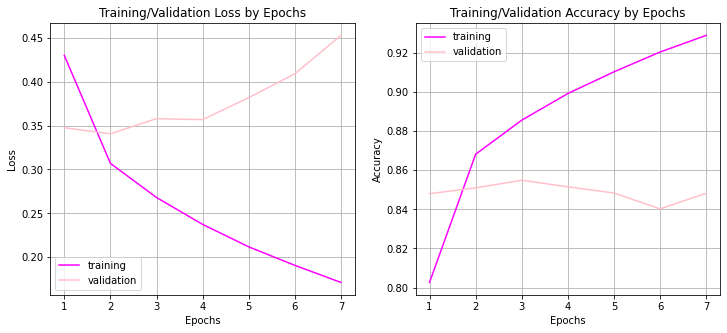

>>> Minimum Validation Loss     :  0.340693861246109
>>> Maximum Validation Accuracy :  0.8548404574394226
>>> Test performance (loss)     :  0.4467940330505371
>>> Test performance (accuracy) :  0.8451899290084839
>>> The model performance evaluation is successfully finished.


In [11]:
model = learingPipeline(embedding_flag = False,
                    embedding_matrix = embedding_matrix,
                    maxlen = maxlen,
                    X = X_train, y = y_train, X_test = X_test, y_test = y_test,
                    model = RNN)

In [12]:
print(">>> Similar words from learning model")
print(findSimilarWords(model, "안녕"))

>>> Similar words from learning model
[('곤란', 0.8963968753814697), ('킹콩', 0.8960607647895813), ('조셉', 0.887991726398468), ('와요', 0.8874593377113342), ('나와요', 0.8854082226753235), ('훼손', 0.8820582032203674), ('할껄', 0.8817715048789978), ('보여요', 0.8813858032226562), ('어긋난', 0.8804091811180115), ('인과', 0.8765929341316223)]


2. Test with **CNN** model

>>> Training & validation report


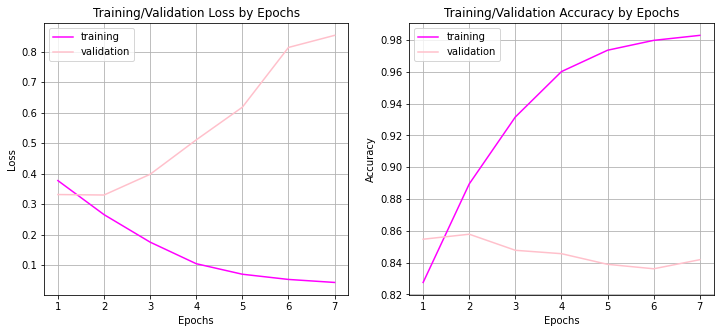

>>> Minimum Validation Loss     :  0.32993221282958984
>>> Maximum Validation Accuracy :  0.8578503727912903
>>> Test performance (loss)     :  0.8623093366622925
>>> Test performance (accuracy) :  0.8409178853034973
>>> The model performance evaluation is successfully finished.


In [13]:
model = learingPipeline(embedding_flag = False,
                        embedding_matrix = embedding_matrix,
                        maxlen = maxlen,
                        X = X_train, y = y_train, X_test = X_test, y_test = y_test,
                        model = CNN)

In [14]:
print(">>> Similar words from learning model")
print(findSimilarWords(model, "안녕"))

>>> Similar words from learning model
[('상품', 0.6874387860298157), ('안드로메다', 0.6809588074684143), ('실패작', 0.6777905225753784), ('돌려줘', 0.6710547208786011), ('처녀', 0.6637659072875977), ('졸음', 0.6636460423469543), ('망친다', 0.6593692302703857), ('엉망', 0.6555586457252502), ('허망', 0.6534014940261841), ('고르', 0.6514102220535278)]


3. Test with **POOL** model

>>> Training & validation report


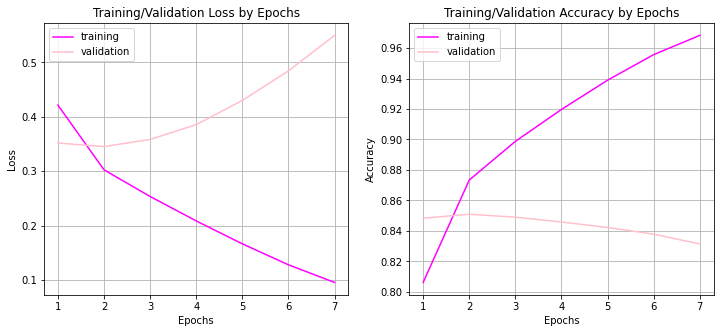

>>> Minimum Validation Loss     :  0.3451767861843109
>>> Maximum Validation Accuracy :  0.8509549498558044
>>> Test performance (loss)     :  0.5501874685287476
>>> Test performance (accuracy) :  0.8312956690788269
>>> The model performance evaluation is successfully finished.


In [15]:
model = learingPipeline(embedding_flag = False,
                        embedding_matrix = embedding_matrix,
                        maxlen = maxlen,
                        X = X_train, y = y_train, X_test = X_test, y_test = y_test,
                        model = POOL)

In [16]:
print(">>> Similar words from learning model")
print(findSimilarWords(model, "안녕"))

>>> Similar words from learning model
[('XX', 0.5819674134254456), ('더러움', 0.5604923963546753), ('개막', 0.557820200920105), ('목적', 0.5475900769233704), ('따라한', 0.5441003441810608), ('질려', 0.5412881970405579), ('억', 0.5408586859703064), ('들어오', 0.5399035811424255), ('C', 0.5382558107376099), ('떨', 0.5354732871055603)]


### 📚 Analyze the performance of embedding vector
네이버 영화 덧글 데이터로부터 자체적으로 만들어낸 embedding vector 를 이용한 학습 실험 결과는 accuracy가 약 84%를 달성했다.  
따라서 프로젝트에 제시된 내용대로 embedding vector를 Word2Vec 을 이용하여 학습을 다시 시도하고자 한다 😅

### 📚 Load Korean Word2Vec

In [17]:
# load Korean words embedding matrix
w2v_ko = keyedvectors.Word2VecKeyedVectors.load(file_path + "word2vec_ko.model")

# Test similarity performance of Korean Word2Vec
w2v_ko.wv.similar_by_word("안녕")

[('행복', 0.6871559023857117),
 ('그대', 0.658285915851593),
 ('추억', 0.6403313875198364),
 ('사랑', 0.6375386714935303),
 ('여러분', 0.6252519488334656),
 ('안녕히', 0.6242714524269104),
 ('당신', 0.6225571036338806),
 ('고마워', 0.6185016632080078),
 ('이별', 0.6147077679634094),
 ('이여', 0.6141240000724792)]

### 📚 Improve embedding matrix using Korean Word2Vec

In [18]:
# improve previous embedding matrix according to Word2Vec_Ko
# Word2Vec_Ko에 기존 embedding matrix 와 일치하는 단어에 대한 데이터가 있다면 대체
embedding_matrix = np.random.rand(TOTAL_WORDS, EMB_VEC_DIM)
for i in range(4, TOTAL_WORDS):
    if num_to_word_dict[i] in w2v_ko.wv:
        embedding_matrix[i] = w2v_ko.wv[num_to_word_dict[i]]

### 📚 Test and evaluate ML model with improved embedding matrix

1. Test with **RNN(LSTM)** model

>>> Training & validation report


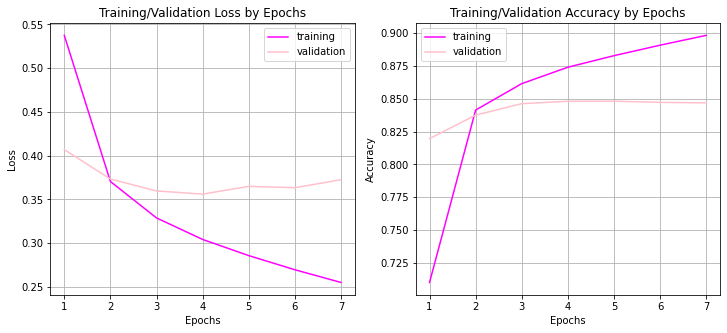

>>> Minimum Validation Loss     :  0.35616520047187805
>>> Maximum Validation Accuracy :  0.848109245300293
>>> Test performance (loss)     :  0.3712722659111023
>>> Test performance (accuracy) :  0.8448847532272339
>>> The model performance evaluation is successfully finished.


In [19]:
model = learingPipeline(embedding_flag = True,
                        embedding_matrix = embedding_matrix,
                        maxlen = maxlen,
                        X = X_train, y = y_train, X_test = X_test, y_test = y_test,
                        model = RNN)

2. Test with **RNN64(LSTM64)** model

>>> Training & validation report


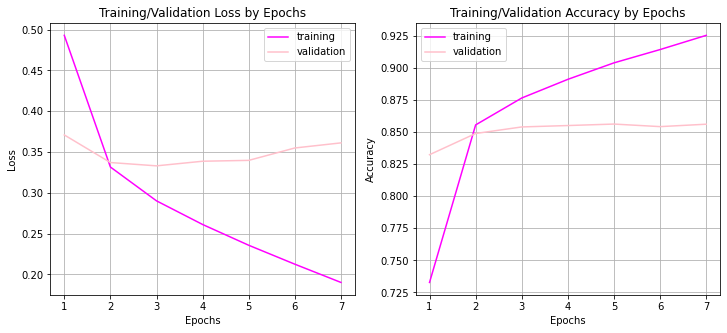

>>> Minimum Validation Loss     :  0.33307793736457825
>>> Maximum Validation Accuracy :  0.8563454151153564
>>> Test performance (loss)     :  0.36313772201538086
>>> Test performance (accuracy) :  0.8544256091117859
>>> The model performance evaluation is successfully finished.


In [20]:
model = learingPipeline(embedding_flag = True,
                        embedding_matrix = embedding_matrix,
                        maxlen = maxlen,
                        X = X_train, y = y_train, X_test = X_test, y_test = y_test,
                        model = RNN_64)

---
**회고록**  
노드 내 영어 문장을 분석하는 실습에서는 embedding vector 크기를 5로 설정하여 자체 학습하여 accuracy를 약 50% 이상을 달성하였고, Word2Vec(embedding vector 크기 100)을 적용하여 accuracy를 약 80% 이상으로 향상시켰다.  
그러나 한국어 문장을 분석하는 실습에서는 Word2Vec 적용 여부와 상관없이 accuracy를 약 84% 이상을 달성하였다.  
영어 문장 실습과 비교했을 때 기본적으로 한국어 데이터에 좀 더 성능이 높게 작용하는 것 같은데, data loader 함수가 단어를 쪼개는 아이디어가 탁월하거나 한국어 자체가 문맥 파악이 비교적 더 직관적인 것 같다. 

model.add(tf.keras.layers.LSTM()) 함수를 LSTM(8)에서 LSTM(64)로 향상시켰더니 85% 이상의 accuracy를 달성할 수 있었다.
실험 시간 자체는 크게 차이가 나지 않았던 것 같은데, 이렇게 성능을 향상시킬 수 있다니 신기하다 :D

학습 알고리즘에 대해 아무것도 몰랐을 때는 사람들이 새로운 학습 알고리즘 연구는 안 하고 그냥 기존 학습 알고리즘에서 파라미터 값 조정하는 데에만 매달리는 게 이해하기 어려웠는데, 이제야 알 것 같다 -_-ㅋㅋㅋ